In [ ]:
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sb
from pathlib import Path
import matplotlib.pyplot as plot
from datetime import datetime

In [ ]:
DIR = r"C:\Temp\ML_Fruad_Files"
DIR_PROTOCOL = r"C:\Temp\ML_Fruad_Files\Protocol"
DIR_Neighborhood = r"C:\Temp\ML_Fruad_Files\Neighborhood_Clusters"

In [ ]:
# creating directory and folder
folder_path = Path(DIR_PROTOCOL)
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
df=pd.read_pickle(f'{DIR}\df_after_stage5.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29210 entries, 0 to 29209
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   is_female                            29210 non-null  int64  
 1   lat                                  29210 non-null  float64
 2   long                                 29210 non-null  float64
 3   amt                                  29210 non-null  float64
 4   merch_lat                            29210 non-null  float64
 5   merch_long                           29210 non-null  float64
 6   num_neighborhoods                    29210 non-null  int64  
 7   distance_merch_cust                  29210 non-null  float64
 8   trans_hour                           29210 non-null  int64  
 9   num_transactions                     29210 non-null  int64  
 10  max_amount                           29210 non-null  float64
 11  min_amount                  

## Model Selection

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#import pkg_resources

In [ ]:
# Remark: 2 models i took it out from use.
#1. SVC model took long time - so i took it out from use.
#2. Logistic Regression - displayed an error message about being unable to complete the iterations -> "STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT"
# when i use pipeline - it doent help. when i raised the level of max_iter - it was very slow and still show the error message

#    "Logistic Regression": Pipeline([
#        ("scaler", StandardScaler()),
#        ("clf", LogisticRegression(
#            solver='saga',
#            max_iter=1000,
#            random_state=42
#        ))
#    ]),

models = {
    "DecisionTree" : DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGB": xgb.XGBClassifier(random_state=42),
    "SVC": SVC(random_state=42)
}

In [ ]:
from sklearn import metrics

def classificationMetrics(y_true, y_pred):
    prf1 = metrics.precision_recall_fscore_support(y_true, y_pred, zero_division=0)

    return {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': prf1[0][1],
        'Recall': prf1[1][1],
        'F1-Score': prf1[2][1],
        'Confusion Matrix': metrics.confusion_matrix(y_true, y_pred)
    }


In [ ]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Configured to prevent a warning message about the number of cores

In [ ]:
from imblearn.over_sampling import RandomOverSampler

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

balancer = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)

In [ ]:
print(f" X:{X.shape}") # 29210 rows
print(f" X_train:{X_train.shape}") # 23368 rows
print(f" X_test:{X_test.shape}") # 5842 rows
print(f" X_train_bal:{X_train_bal.shape}") # 46190 rows

print(f" y_test:{y_test.shape}") # 46190 rows
print(f" y_train_bal:{y_train_bal.shape}") # 46190 rows
# The minority class (is_fraud = 1) is very small. Therefore :

# RandomOverSampler:
# Increasing the number of examples in the minority category (fraud group)

 X:(29210, 31)
 X_train:(23368, 31)
 X_test:(5842, 31)
 X_train_bal:(46358, 31)
 y_test:(5842,)
 y_train_bal:(46358,)


In [ ]:
# run all models and save the results

results = []

for model_name, model in models.items():
        try:

            model.fit(X_train_bal, y_train_bal)
            y_pred = model.predict(X_test)

            metrics_result = classificationMetrics(y_test, y_pred)

            results.append({
                "Model": model_name,
                **metrics_result
            })

            print(f" {datetime.now().strftime('%d/%m/%y %H:%M')} -> {model_name} model " )

        except Exception as e:
            print(f"❌ Error in {model_name}: {e}")
results_df = pd.DataFrame(results)
#results_df


 10/11/25 21:54 -> DecisionTree model 
 10/11/25 21:54 -> RandomForest model 
 10/11/25 21:54 -> AdaBoost model 
 10/11/25 21:55 -> GradientBoosting model 
 10/11/25 21:55 -> XGB model 
 10/11/25 21:58 -> SVC model 


In [ ]:
results_df.sort_values(by=['F1-Score','Recall'])

#In fraud detection performance metrics, **Recall is the most critical metric**,
#as it measures how many of the real frauds we were able to detect.
#Precision is important, but to a lesser extent, because false positives can be handled by humans, while missing a fraud can cause financial damage.
#F1-Score, which is a harmonic average of Recall and Precision, and provides a balanced measure that reflects the quality of the model when both are taken into account.

,Model,Accuracy,Precision,Recall,F1-Score,Confusion Matrix
5,SVC,0.943170,0.069565,0.685714,0.126316,"[[5486, 321], [11, 24]]"
2,AdaBoost,0.945567,0.094556,0.942857,0.171875,"[[5491, 316], [2, 33]]"
3,GradientBoosting,0.970045,0.160194,0.942857,0.273859,"[[5634, 173], [2, 33]]"
0,DecisionTree,0.994180,0.510638,0.685714,0.585366,"[[5784, 23], [11, 24]]"
4,XGB,0.996063,0.630435,0.828571,0.716049,"[[5790, 17], [6, 29]]"
1,RandomForest,0.997604,0.862069,0.714286,0.781250,"[[5803, 4], [10, 25]]"


In [ ]:
def show_Confusion_matrix_in_precentage(cm, model_name):

    # sum all
    #cm_sum = np.sum(cm)
    #cm_percent = cm / cm_sum * 100
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plot.figure(figsize=(5,4))
    sb.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues')  # fmt=".2f" כדי להראות אחוזים עם שתי ספרות אחרי הנקודה
    plot.title(f"Confusion Matrix (%) - {model_name}")
    plot.xlabel("Predicted")
    plot.ylabel("Actual")
    plot.show()

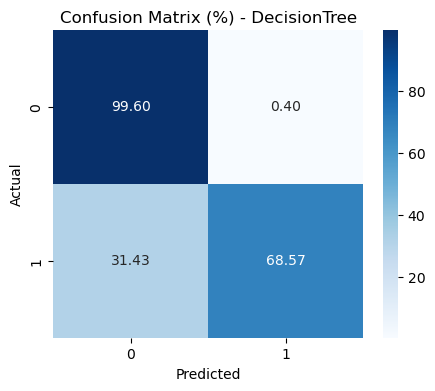

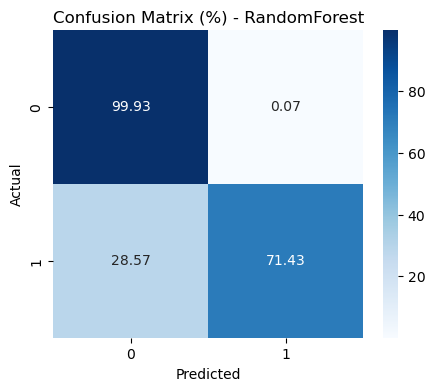

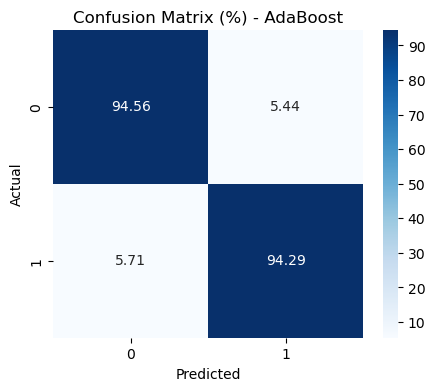

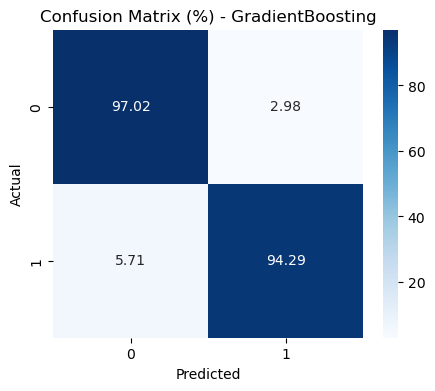

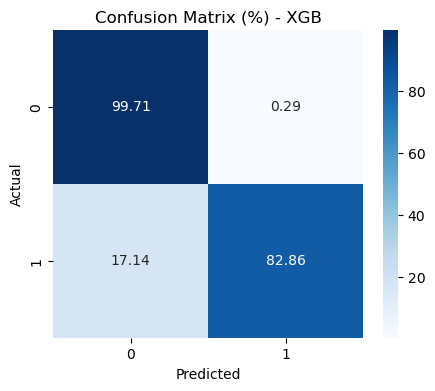

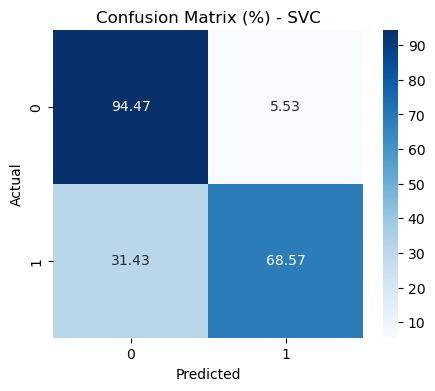

In [ ]:
# show Confusion Matrix in precentage for all model
for model_name, model in models.items():
    cm_xgboost = results_df[results_df['Model'] == model_name]['Confusion Matrix'].values[0]
    show_Confusion_matrix_in_precentage(np.array(cm_xgboost), model_name)

**conclusions:**

the best models are RandomForest, Xgboost
2 The models detect fraud well and do not create many false alerts, meaning they do not detect lots of false identification.

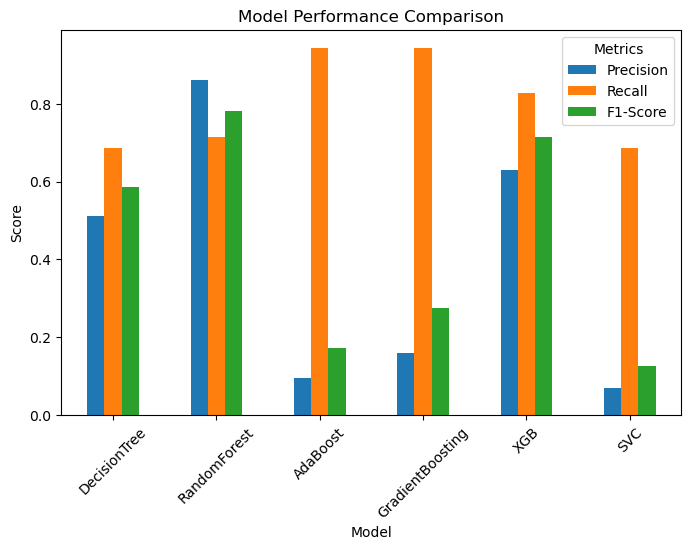

In [ ]:

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']

# Set the model as the X-axis
plot_df = results_df.set_index('Model')[metrics_to_plot]

# Draw the graph
plot_df.plot(kind='bar', figsize=(8,5))
plot.title('Model Performance Comparison')
plot.ylabel('Score')
plot.xlabel('Model')
plot.xticks(rotation=45)
plot.legend(title='Metrics')

plot.show()

**conclusions:**

RandomForest and XgBoost are the best models because both has high Recall (identify lots of fraud)
and both has high F1-Score.


## FineTuning

In [ ]:

#param_grid_xgb = {
#   'n_estimators': [100, 200, 300],
#   'max_depth': [3, 5, 7],
#   'learning_rate': [0.01, 0.05, 0.1],
#   'subsample': [0.7, 0.8, 1],
#   'colsample_bytree': [0.7, 0.8, 1]
#}

param_grid_xgb = {
    'n_estimators': [100, 200],         #number of trees
    'max_depth': [3, 5],                # maximum depth
    'learning_rate': [0.05, 0.1],       # learning rate
    'subsample': [0.8, 1],              # percentage of data in each tree
    'colsample_bytree': [0.8, 1]        # Percentage of features in each tree
}
xgb_model = xgb.XGBClassifier(random_state=42)

In [ ]:
# Create GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='recall',   # maximize Recall
    cv=5,               # Cross-validation 5-fold
    verbose=2,
    n_jobs=-1           # All processor cores
)

In [ ]:
grid_xgb.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='recall', verbose=2)

In [ ]:
grid_xgb.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 200,
 'subsample': 0.8}

In [ ]:
best_xgb = grid_xgb.best_estimator_

In [ ]:
y_final_pred = best_xgb.predict(X_test)

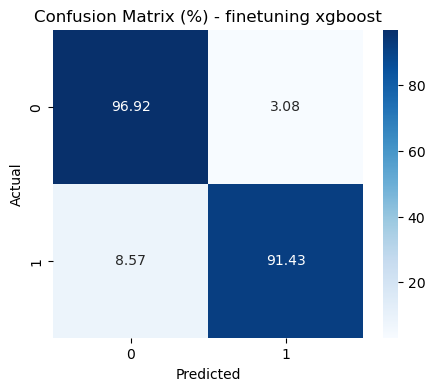

In [ ]:
cm_final_xgboost = confusion_matrix(y_test, y_final_pred)
show_Confusion_matrix_in_precentage(np.array(cm_final_xgboost), 'finetuning xgboost')

In [ ]:
cm_final_xgboost

array([[5628,  179],
       [   3,   32]])

In [ ]:
classificationMetrics(y_test, y_final_pred)

{'Accuracy': 0.968846285518658,
 'Precision': np.float64(0.15165876777251186),
 'Recall': np.float64(0.9142857142857143),
 'F1-Score': np.float64(0.2601626016260163),
 'Confusion Matrix': array([[5628,  179],
        [   3,   32]])}

In [ ]:
#from sklearn.metrics import confusion_matrix, classification_report

print("Best Parameters:", grid_xgb.best_params_)
print("\nConfusion Matrix:\n", cm_final_xgboost)
print("\nClassification Report:\n", classification_report(y_test, y_final_pred))


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Confusion Matrix:
 [[5628  179]
 [   3   32]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.97      0.98      5807
        True       0.15      0.91      0.26        35

    accuracy                           0.97      5842
   macro avg       0.58      0.94      0.62      5842
weighted avg       0.99      0.97      0.98      5842



**conclusions:**
Now the model almost never misses fraud
But it "suspiciously" many legitimate transactions